In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

<h4>period = year, month, day, hour, minute

In [72]:

class Stock:
    def __init__(self, name, period):
        self.name = name  # Store stock name
        self.period = period #year, month, day, hour, minute
        
        # loads minute if hourly and day for the rest 
        if self.period in ('minute', 'hour'):
            self.file = f'csvs/{self.name}.csv'
        else:
            self.file = f'day/{self.name}.csv'

        # Load CSV and ensure DatetimeIndex
        self.df = pd.read_csv(self.file, parse_dates=['Datetime'], index_col='Datetime')
        # Ensure 'Datetime' is a proper index
        self.df.index = pd.to_datetime(self.df.index, errors='coerce')

        # If the index is timezone-aware, convert to UTC
        if self.df.index.tz is not None:
            self.df.index = self.df.index.tz_convert('UTC')
        else:
            # If timezone-naive, localize to UTC
            self.df.index = self.df.index.tz_localize('UTC', errors='coerce')
        # Decide if we need to convert to UTC based on the period
        self.butc = period in ('hour', 'minute')

        # Convert to UTC only if required
        if self.butc:
            self.df.index = self.df.index.tz_convert('UTC')



        
        #resample data for wnted period
        if self.period == 'year':
            # ✅ Apply aggregation after resampling
            self.df = self.df.resample('YE').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}).ffill()
            print(self.df) 
            self.df[self.period] = self.df.index.year
       
        # Monthly timeframe
        elif self.period == 'month':
            self.df = self.df.resample('ME').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}).ffill()
            print(self.df) 
            self.df[self.period] = self.df.index.month
            
        elif self.period == 'dayofweek':
            # Extract period from datetime index
            self.df[self.period] = self.df.index.dayofweek #

        elif self.period == 'day':
            # Extract period from datetime index
            self.df[self.period] = self.df.index.day #
        
        elif self.period == 'hour':
            self.df[self.period] = self.df.index.hour
        
        elif self.period == 'minute':
             self.df[self.period] = self.df.index.minute
            
        else:
            raise ValueError(f"Invalid period: {self.period}")
        
        # Ensure the period column exists before grouping
        if self.period not in self.df.columns:
            raise KeyError(f"Column '{self.period}' was not created in self.df")

        # print(self.df.columns)
        
        # Compute period aggregated metrics safely using `.agg()`
        grouped_price_change = self.df.groupby(self.period).agg(price_change=('Close', lambda x: (x - self.df.loc[x.index, 'Open']).mean()))

        volume_mean = self.df.groupby(self.period).agg(mean_volume=('Volume', 'mean'))

        interhour_volatility = self.df.groupby(self.period).agg(volatility=('High', lambda x: (x - self.df.loc[x.index, 'Low']).mean()))

        # Normalize volume and drop the original mean_volume column
        volume_mean['normalized_volume'] = (volume_mean['mean_volume'] - volume_mean['mean_volume'].min()) / (volume_mean['mean_volume'].max() - volume_mean['mean_volume'].min())
        volume_mean.drop(columns=['mean_volume'], inplace=True)

        # Merge all computed metrics into a single DataFrame
        self.grouped_df = grouped_price_change.merge(volume_mean, left_index=True, right_index=True).merge(
            interhour_volatility, left_index=True, right_index=True
        )

        # Rename columns to include stock name
        self.grouped_df.columns = [f"{self.name}_{col}" for col in self.grouped_df.columns]

        # Drop the period column as it's now in index and remove the original df[period] column
        self.df.drop(columns=[self.period], inplace=True)

        # Convert columns to float32 to save memory
        self.df = self.df.astype({'Open': 'float32', 'Close': 'float32', 'High': 'float32', 'Low': 'float32', 'Volume': 'float32'})
        self.grouped_df = self.grouped_df.astype('float32')

        # Delete intermediate variables to free memory
        del grouped_price_change, volume_mean, interhour_volatility

    def get_grouped_data(self):
        """Return the grouped and processed DataFrame."""
        return self.grouped_df


In [73]:
stocks = ['IWM', 'NVDA', 'QQQ', 'SPY', 'TSLA']
periods = ['minute', "hour", 'day', 'dayofweek', 'month']
stock_objects = [Stock(stock, period ) for stock, period in itertools.product(stocks, periods)]



                                 Open        High         Low       Close  \
Datetime                                                                    
2000-05-31 00:00:00+00:00   32.958559   34.881338   32.800213   34.440231   
2000-06-30 00:00:00+00:00   35.147109   38.386837   35.147109   37.430573   
2000-07-31 00:00:00+00:00   37.345680   39.541164   35.263374   36.395061   
2000-08-31 00:00:00+00:00   36.123455   39.224292   35.512352   38.930054   
2000-09-30 00:00:00+00:00   39.111127   39.405343   36.337208   37.654419   
...                               ...         ...         ...         ...   
2024-07-31 00:00:00+00:00  202.227451  227.177988  198.610566  222.438278   
2024-08-31 00:00:00+00:00  222.348853  223.461735  195.450763  218.682297   
2024-09-30 00:00:00+00:00  216.744667  223.511429  202.913091  220.236099   
2024-10-31 00:00:00+00:00  219.518229  226.497522  213.964729  217.115372   
2024-11-30 00:00:00+00:00  218.850222  220.315871  217.693652  218.331757   

In [74]:
for stock in stock_objects:
    print(stock.grouped_df)

        IWM_price_change  IWM_normalized_volume  IWM_volatility
minute                                                         
0              -0.043183               0.180924        0.223049
1               0.000098               0.109053        0.170035
2              -0.006163               0.068130        0.168310
3               0.005577               0.022885        0.152971
4              -0.005114               0.042451        0.152770
5               0.003975               0.053640        0.161905
6               0.016137               0.052420        0.165123
7               0.000646               0.010834        0.159919
8               0.017244               0.034982        0.148166
9               0.001823               0.028915        0.131961
10             -0.009673               0.050932        0.156295
11             -0.023695               0.544544        0.147848
12              0.003323               0.075036        0.144854
13              0.002551               0

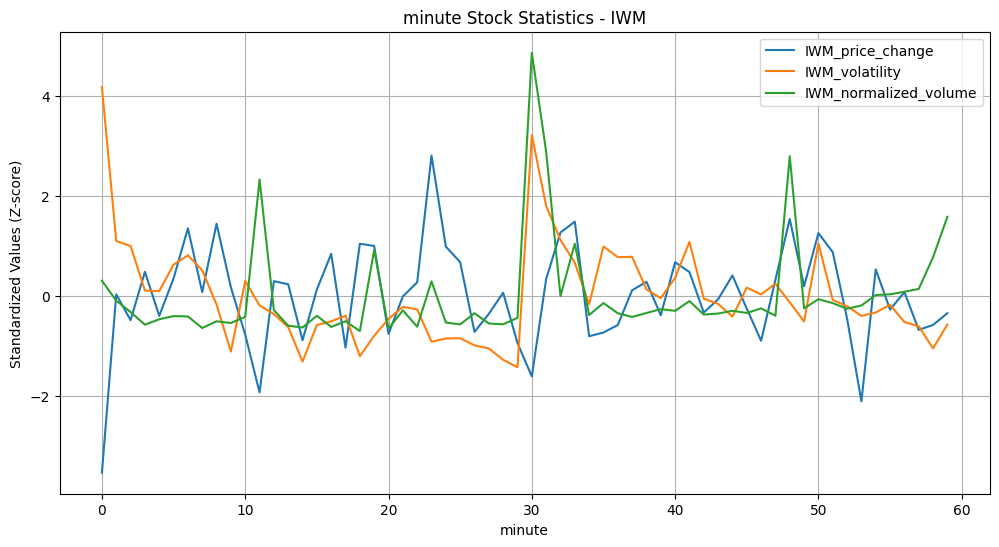

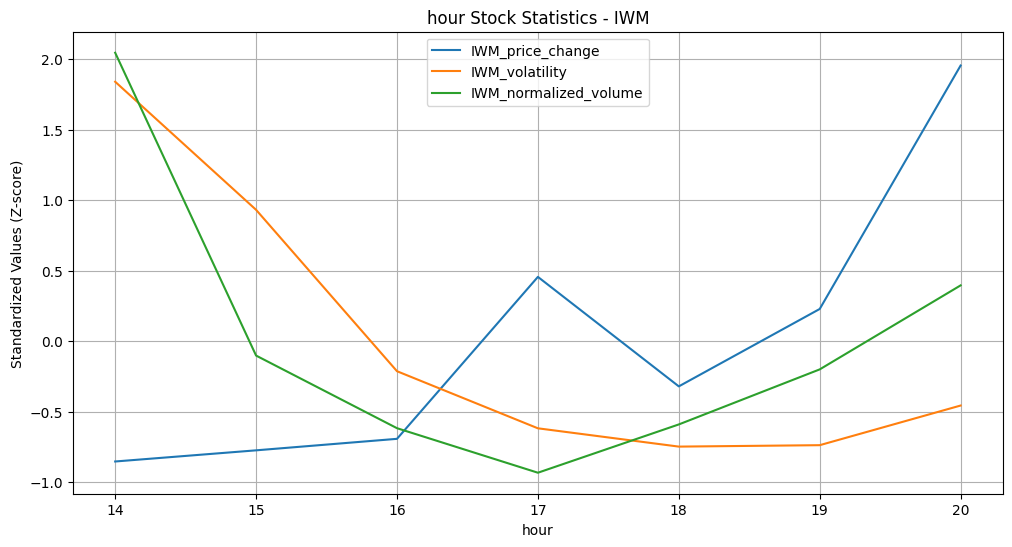

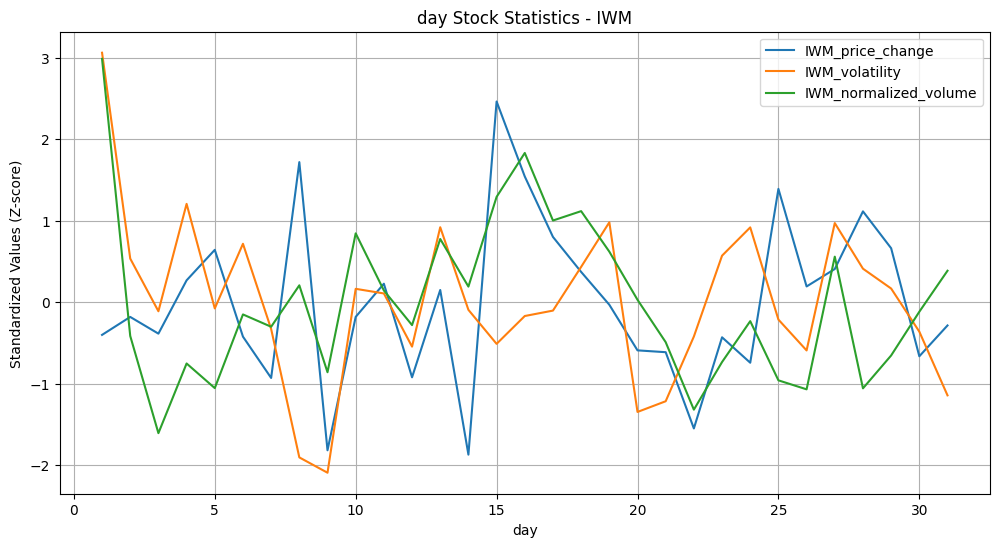

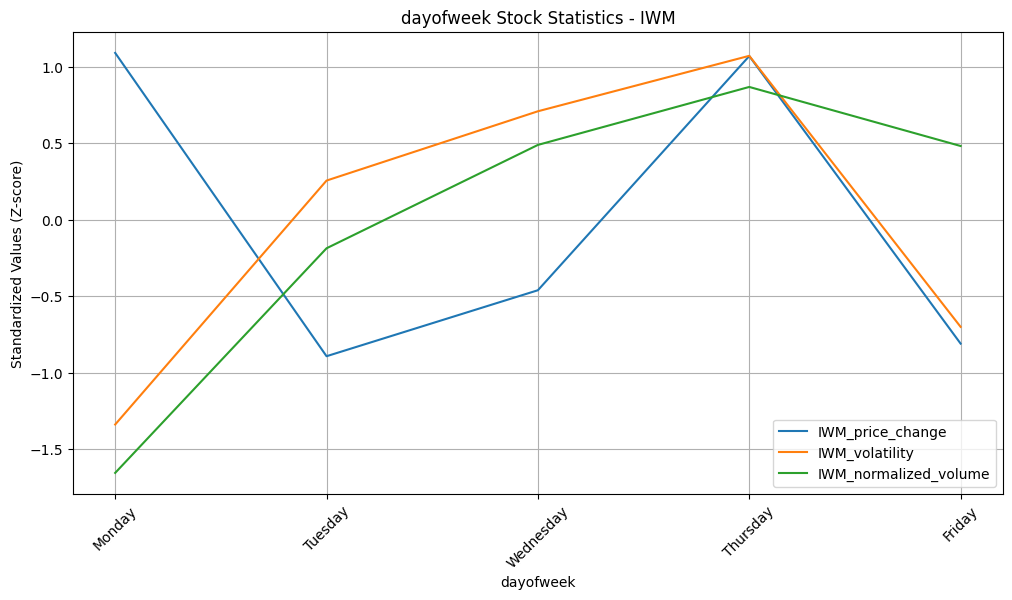

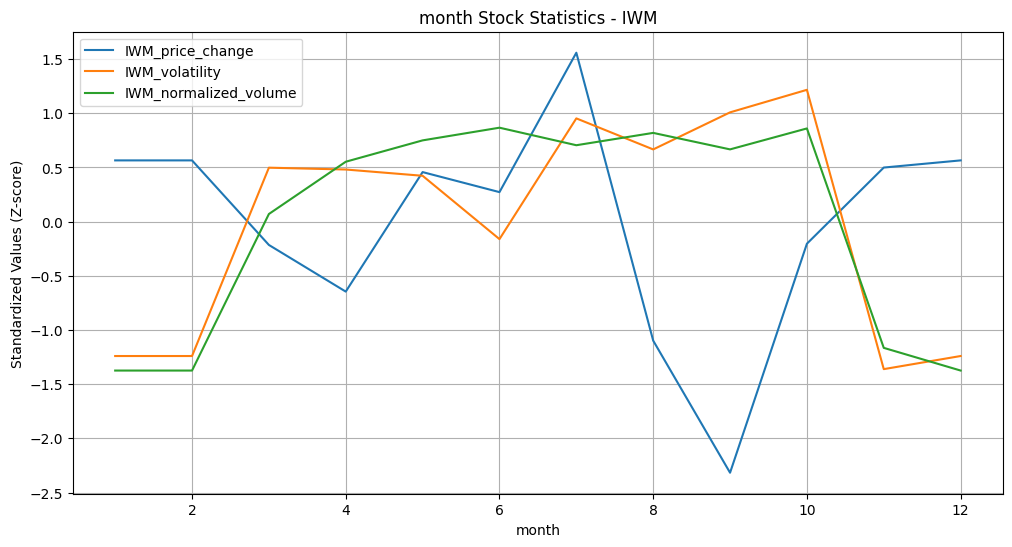

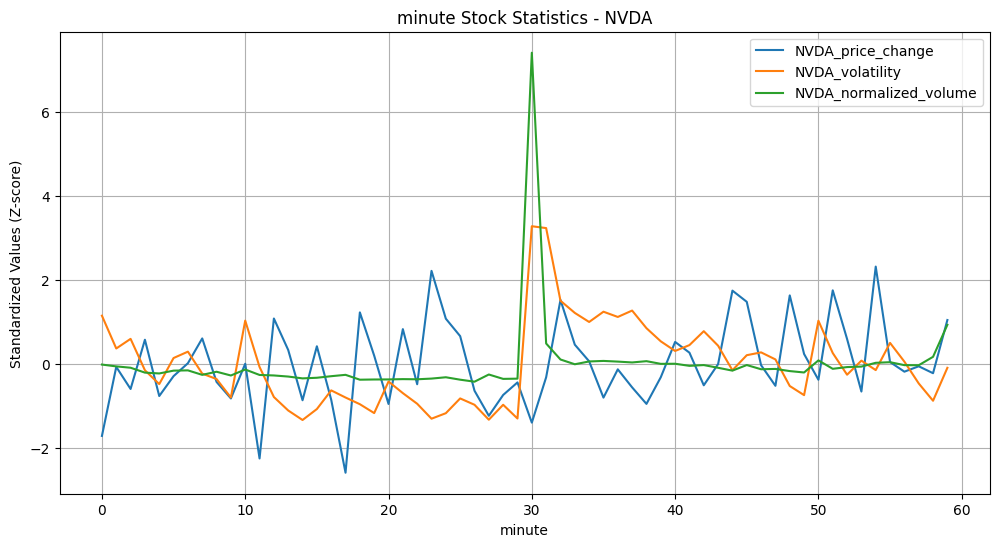

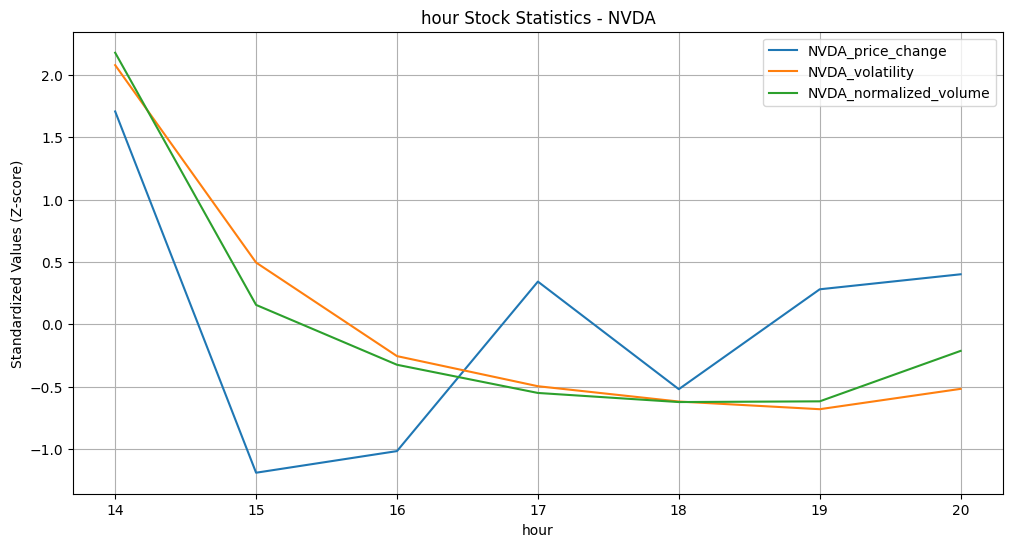

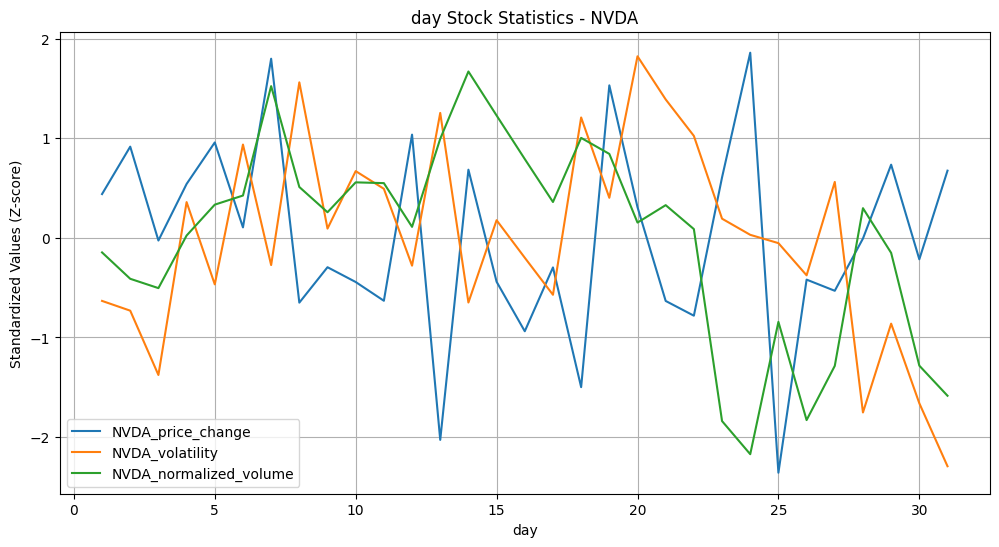

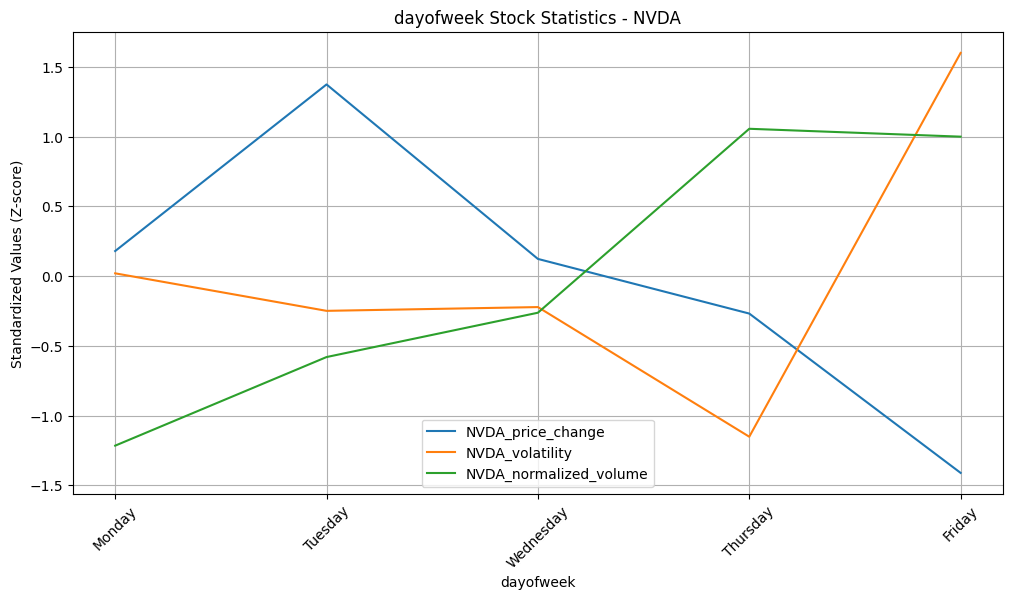

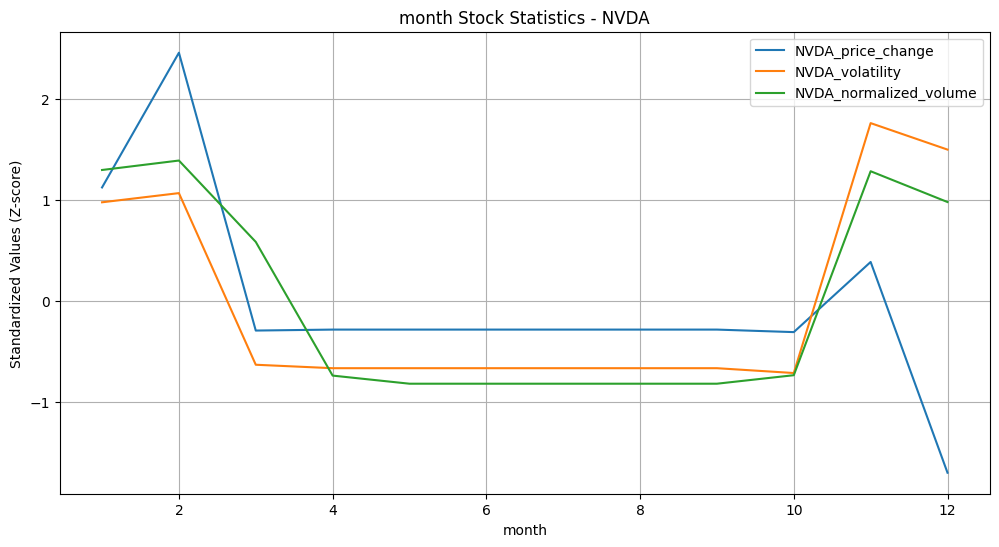

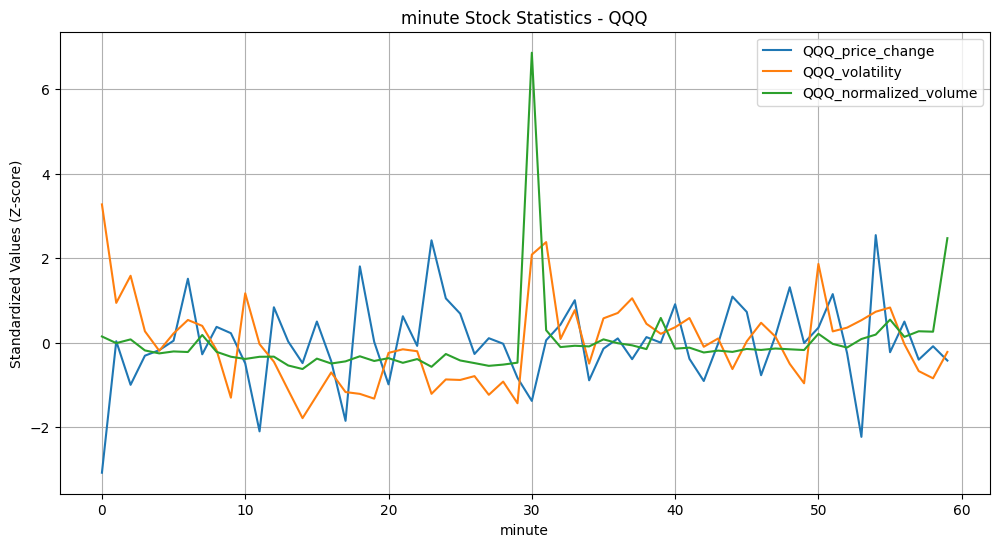

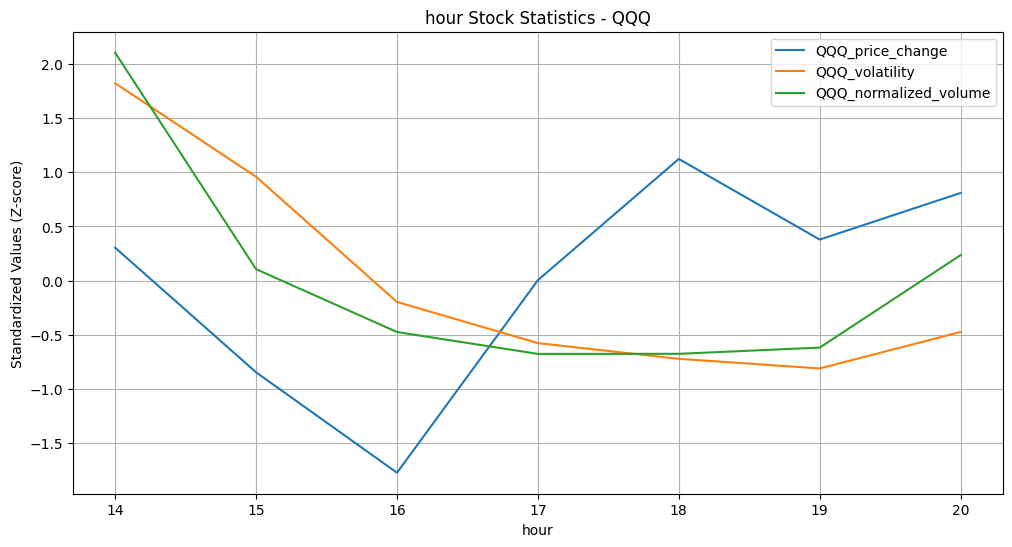

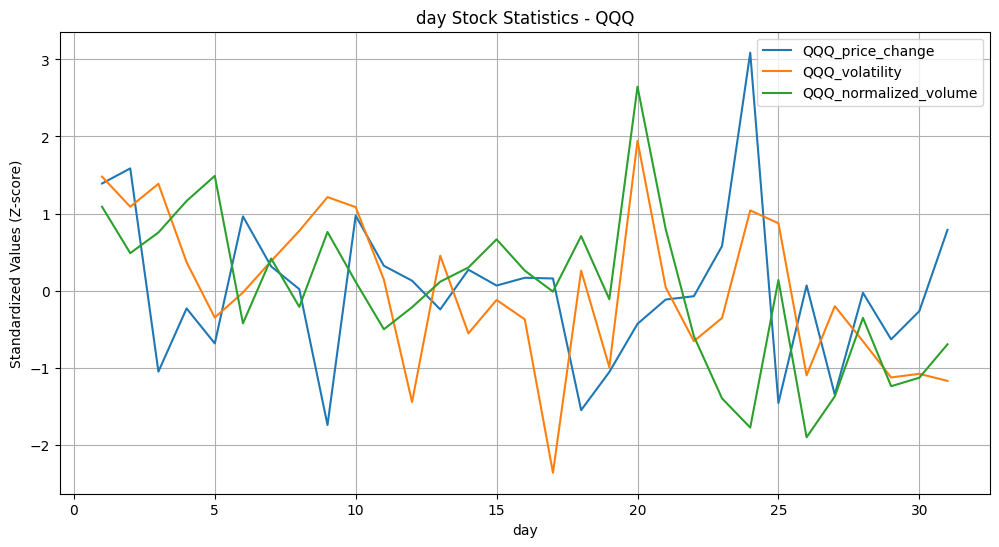

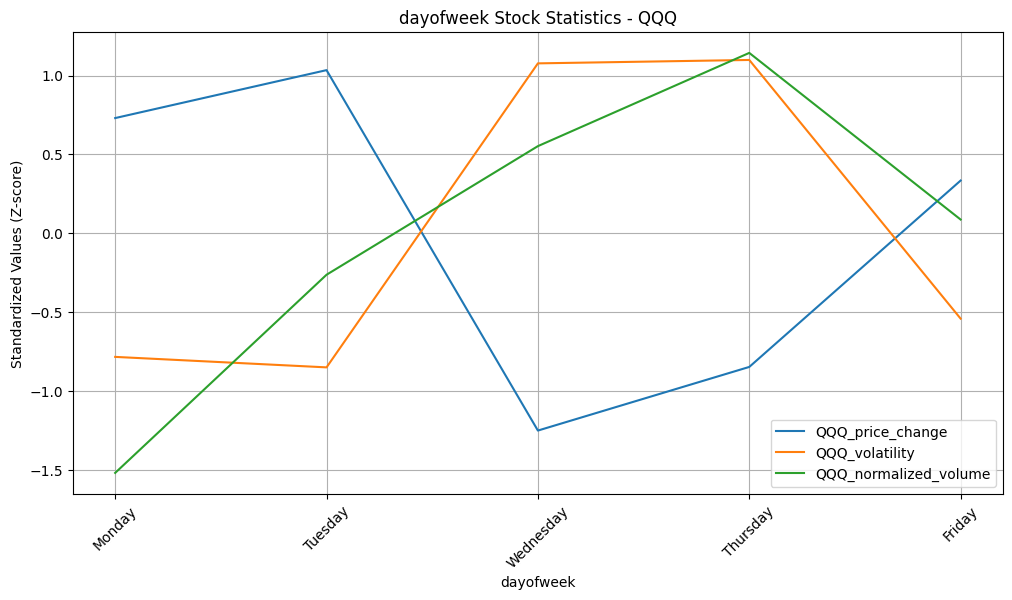

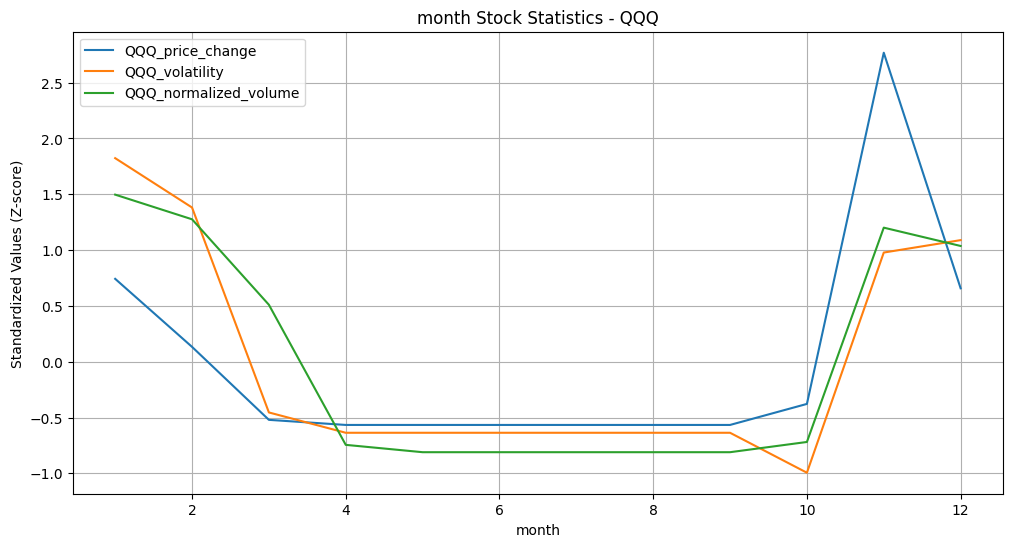

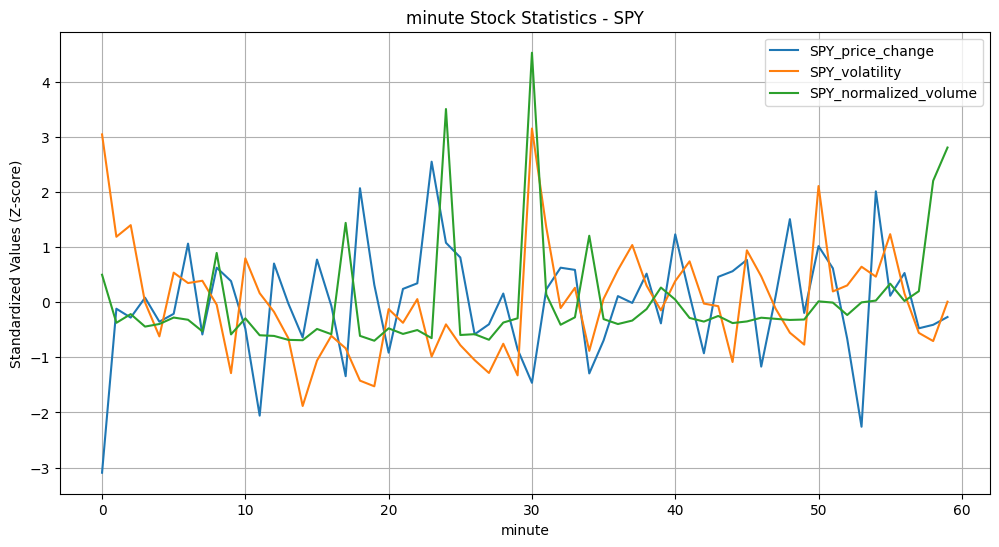

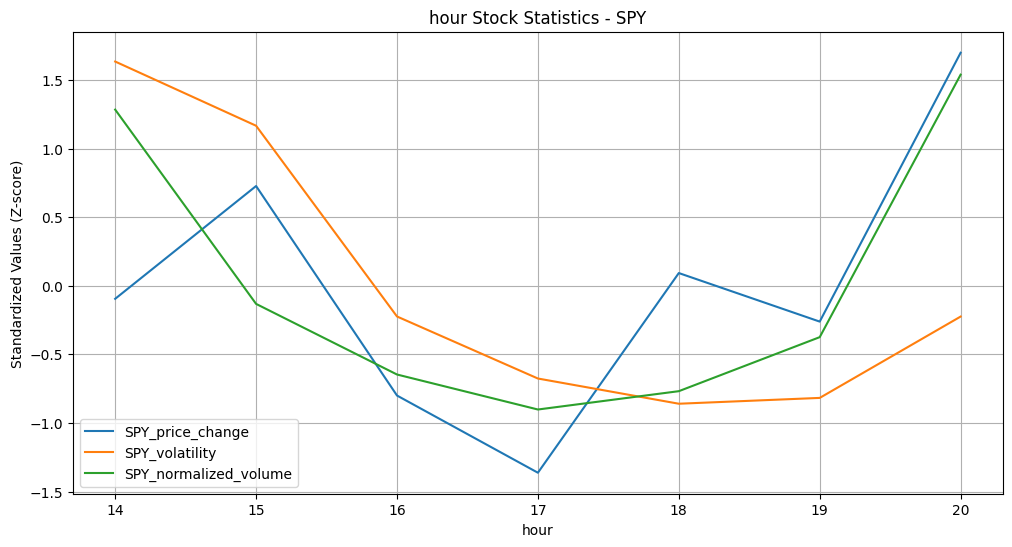

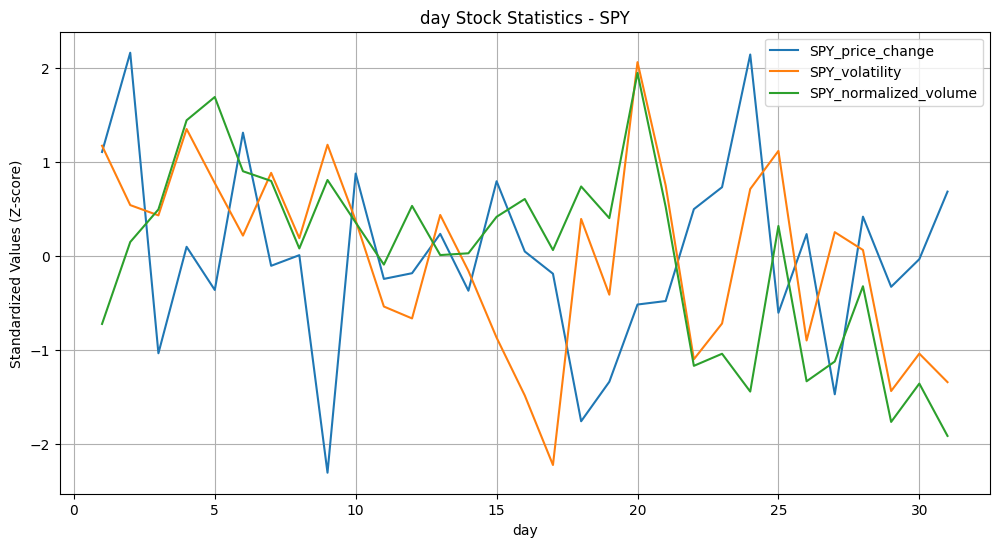

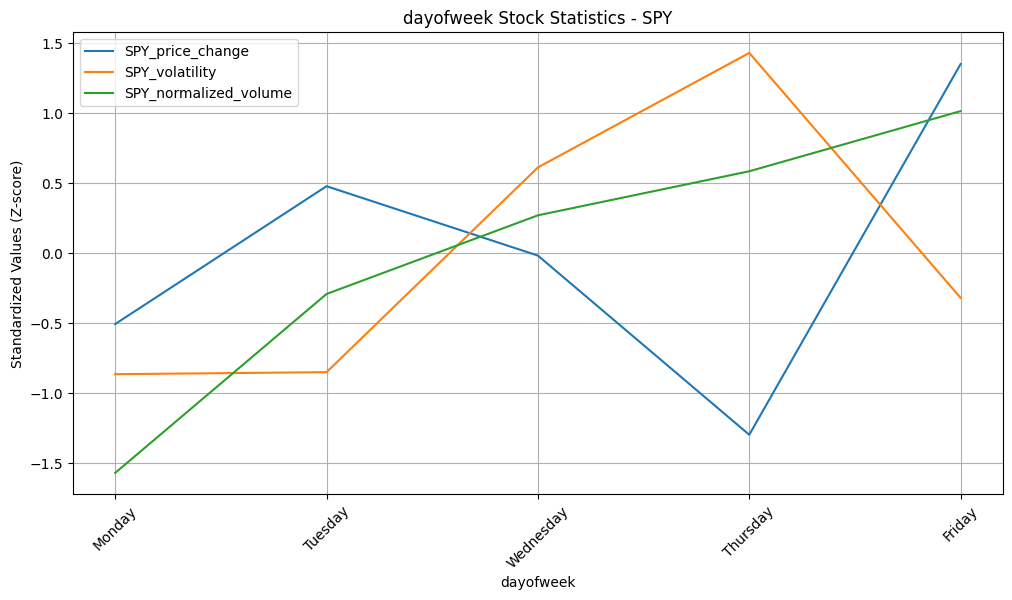

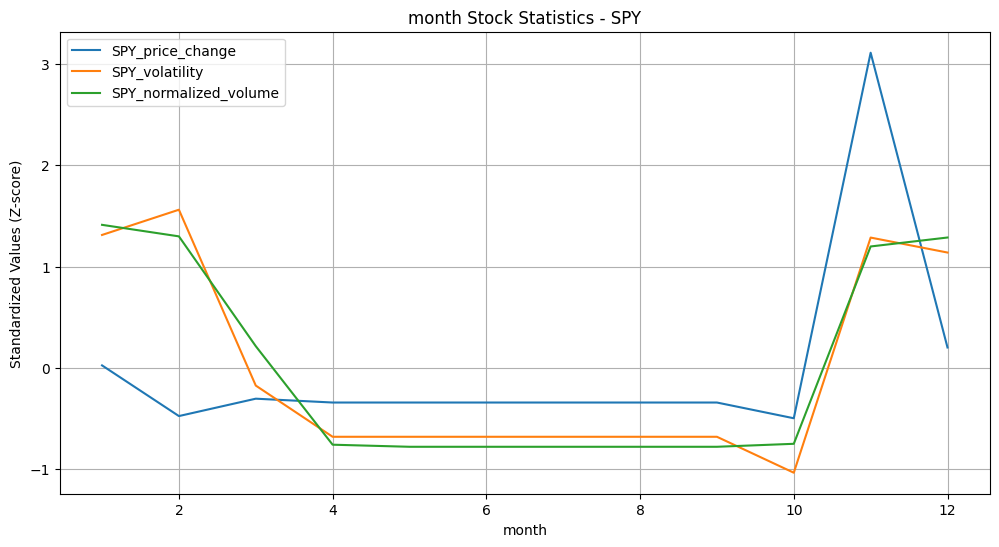

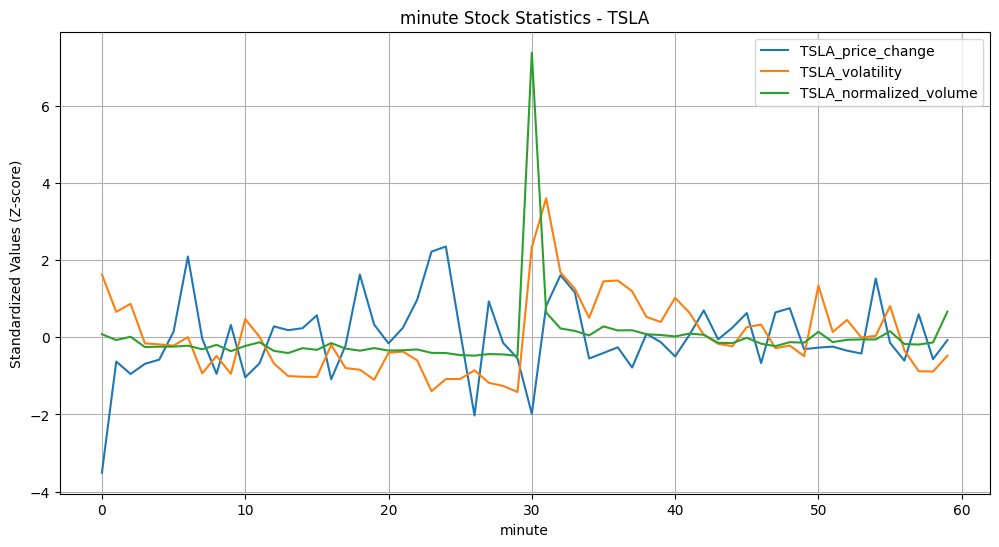

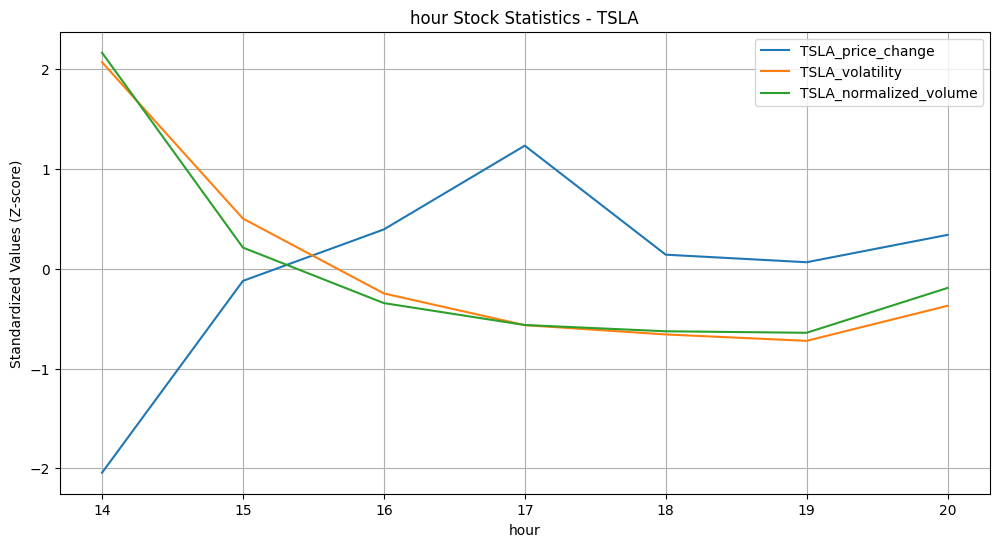

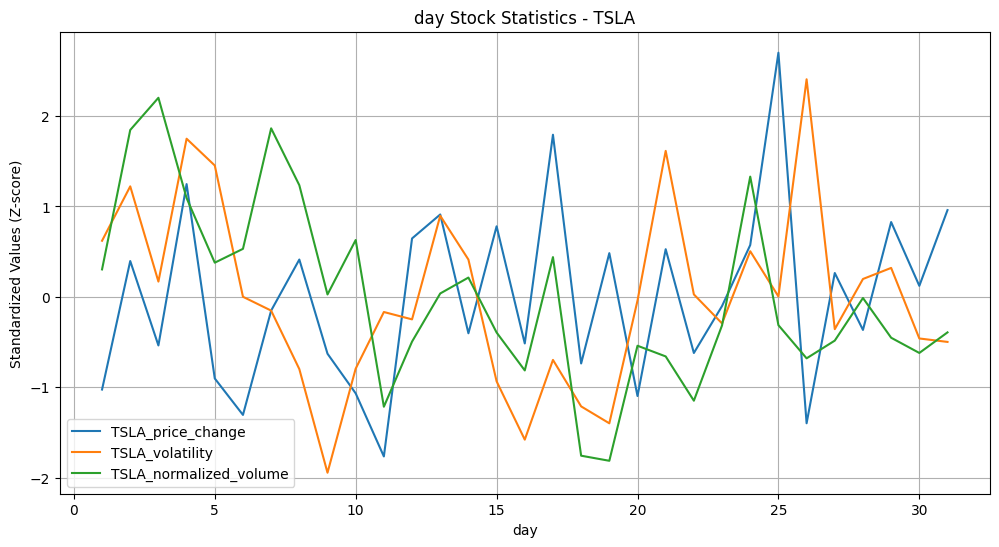

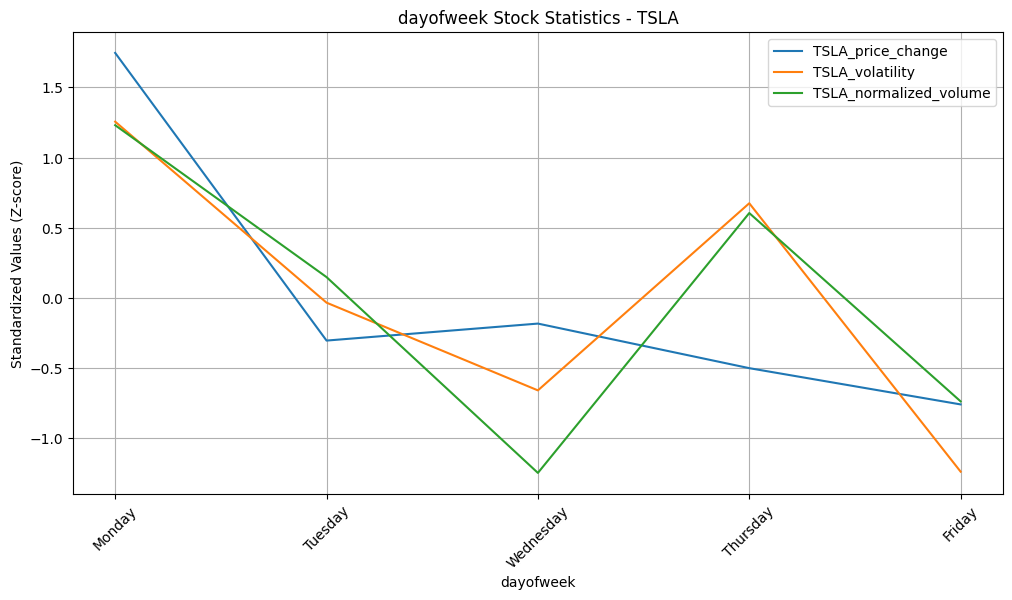

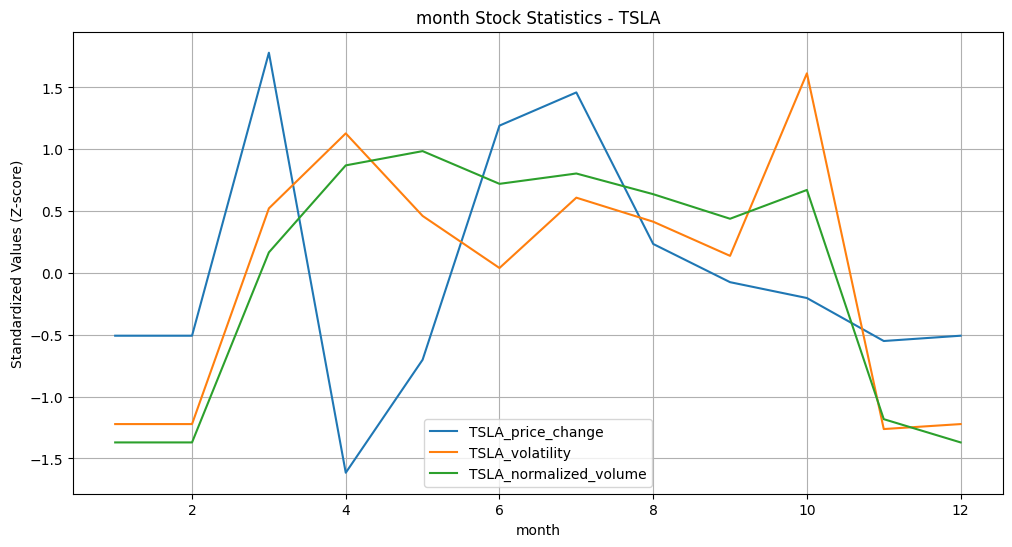

In [75]:


days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

for stock in stock_objects:
    # Select only the numerical columns for normalization
    metrics = [f"{stock.name}_price_change", f"{stock.name}_volatility", f"{stock.name}_normalized_volume"]
    available_metrics = [col for col in metrics if col in stock.grouped_df.columns]

    # Apply Z-score normalization (standardization)
    for col in available_metrics:
        mean_val = stock.grouped_df[col].mean()
        std_val = stock.grouped_df[col].std()
        if std_val != 0:  # Avoid division by zero
            stock.grouped_df[col] = (stock.grouped_df[col] - mean_val) / std_val

    # Create a plot
    plt.figure(figsize=(12, 6))

    # Plot all metrics after normalization
    for column in available_metrics:
        plt.plot(stock.grouped_df.index, stock.grouped_df[column], label=column)

    # Ensure x-axis labels match (Convert index to weekday names dynamically)
    if stock.period == 'dayofweek':
        if len(stock.grouped_df.index) == len(days):  #
            plt.xticks(ticks=stock.grouped_df.index, labels=days, rotation=45)
        else:
            print(f"Warning: Mismatch between index count ({len(stock.grouped_df.index)}) and day labels.")

    # Labels and Title
    plt.xlabel(stock.period)
    plt.ylabel("Standardized Values (Z-score)")
    plt.title(f"{stock.period} Stock Statistics - {stock.name}")
    plt.legend()
    plt.grid()

    # Show the plot
    plt.show()
